# Session 10

## Cloning the repo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/ERA-v1

/content/drive/MyDrive/Github/ERA-v1


In [ ]:
! git config --global user.email "me18b059@smail.iitm.ac.in"
! git config --global  pull.ff true
! git stash push --include-untracked
! git stash drop
! git pull

In [4]:
%cd S12/

/content/drive/MyDrive/Github/ERA-v1/S12


# CIFAR-10 dataset classification

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

# Importing basic dependencies

In [5]:
!pip install torchmetrics
!pip install torch_lr_finder
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.1/731.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 8.2 MB/s eta 0:00:00


In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
# del model
import torch
from Utilities.model import Net
import torch.nn.functional as F
from torchsummary import summary
from Utilities import config

torch.manual_seed(config.SEED)

# Model Initialization & Summary

In [80]:
criterion = F.cross_entropy

model = Net(
    num_classes=config.NUM_CLASSES,
    dropout_percentage=config.DROPOUT_PERCENTAGE,
    norm=config.LAYER_NORM,
    criterion=criterion,
    learning_rate=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY)

summary(model.to(config.ACCELERATOR), input_size=config.INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

# Dataset & Dataloaders

In [81]:
from Utilities.transforms import train_transforms, test_transforms

In [82]:
from Utilities.dataset import CIFAR10DataModule

kwargs = {'batch_size': config.BATCH_SIZE,
          'shuffle': config.SHUFFLE,
          'num_workers': config.NUM_WORKERS,
          'pin_memory': config.PIN_MEMORY}
data_module = CIFAR10DataModule(train_transforms=train_transforms, val_transforms=test_transforms, **kwargs)

In [83]:
# Call the setup() method before train_dataloader()
data_module.prepare_data()
data_module.setup(stage=None)

# Now you can call train_dataloader()
train_loader = data_module.train_dataloader()

Files already downloaded and verified
Files already downloaded and verified


# Data Exploration

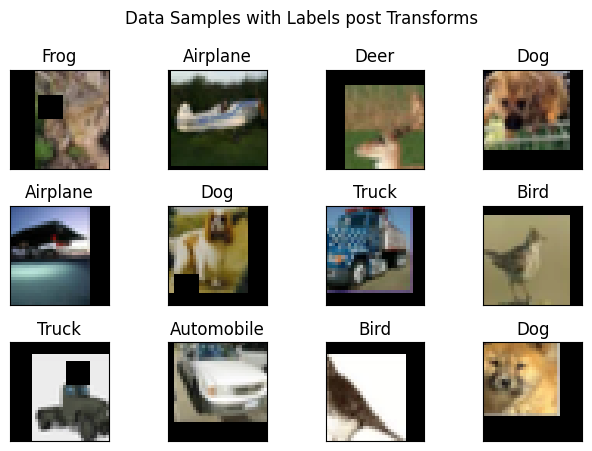

In [12]:
from Utilities.visualize import plot_data_samples, plot_class_label_counts

# plot_class_label_counts(train_loader, classes=config.CLASSES)
plot_data_samples(train_loader, classes=config.CLASSES)

# Training

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.56E-03


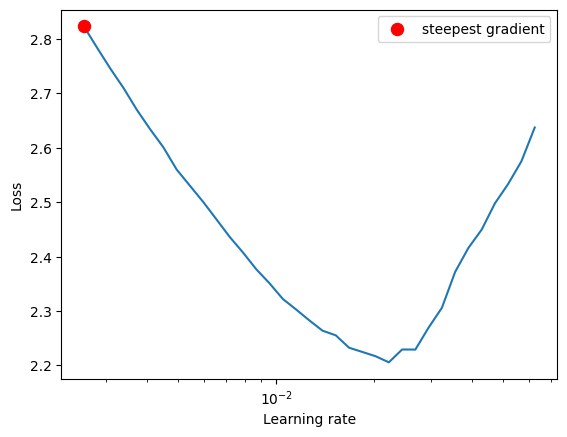

Sanity Checking: 0it [00:00, ?it/s]


Epoch: 0, Val Loss: 2.303018569946289, Val Accuracy: 0.0927734375


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Epoch: 0, Val Loss: 1.702123999595642, Val Accuracy: 0.42329999804496765

Epoch: 0, Train Loss: 1.8644518852233887, Train Accuracy: 0.3246400058269501


Validation: 0it [00:00, ?it/s]


Epoch: 1, Val Loss: 1.1449466943740845, Val Accuracy: 0.5981000065803528

Epoch: 1, Train Loss: 1.2567470073699951, Train Accuracy: 0.5479400157928467


Validation: 0it [00:00, ?it/s]


Epoch: 2, Val Loss: 0.8532384037971497, Val Accuracy: 0.7032999992370605

Epoch: 2, Train Loss: 0.9423277974128723, Train Accuracy: 0.6680200099945068


Validation: 0it [00:00, ?it/s]


Epoch: 3, Val Loss: 0.7151800394058228, Val Accuracy: 0.7592999935150146

Epoch: 3, Train Loss: 0.7540322542190552, Train Accuracy: 0.736299991607666


Validation: 0it [00:00, ?it/s]


Epoch: 4, Val Loss: 0.5832195281982422, Val Accuracy: 0.8001999855041504

Epoch: 4, Train Loss: 0.6525335311889648, Train Accuracy: 0.7747799754142761


Validation: 0it [00:00, ?it/s]


Epoch: 5, Val Loss: 0.6359300017356873, Val Accuracy: 0.7843000292778015

Epoch: 5, Train Loss: 0.5883049368858337, Train Accuracy: 0.7950000166893005


Validation: 0it [00:00, ?it/s]


Epoch: 6, Val Loss: 0.48262616991996765, Val Accuracy: 0.8352000117301941

Epoch: 6, Train Loss: 0.5070803761482239, Train Accuracy: 0.8244799971580505


Validation: 0it [00:00, ?it/s]


Epoch: 7, Val Loss: 0.5159085392951965, Val Accuracy: 0.8294000029563904

Epoch: 7, Train Loss: 0.44362980127334595, Train Accuracy: 0.845300018787384


Validation: 0it [00:00, ?it/s]


Epoch: 8, Val Loss: 0.44008609652519226, Val Accuracy: 0.8517000079154968

Epoch: 8, Train Loss: 0.40053457021713257, Train Accuracy: 0.8615800142288208


Validation: 0it [00:00, ?it/s]


Epoch: 9, Val Loss: 0.5190107226371765, Val Accuracy: 0.8264999985694885

Epoch: 9, Train Loss: 0.36916792392730713, Train Accuracy: 0.8701800107955933


Validation: 0it [00:00, ?it/s]


Epoch: 10, Val Loss: 0.35025638341903687, Val Accuracy: 0.8797000050544739

Epoch: 10, Train Loss: 0.3416558504104614, Train Accuracy: 0.8819400072097778


Validation: 0it [00:00, ?it/s]


Epoch: 11, Val Loss: 0.3904816508293152, Val Accuracy: 0.8683000206947327

Epoch: 11, Train Loss: 0.3163507282733917, Train Accuracy: 0.8899800181388855


Validation: 0it [00:00, ?it/s]


Epoch: 12, Val Loss: 0.3900163173675537, Val Accuracy: 0.8734999895095825

Epoch: 12, Train Loss: 0.2892703115940094, Train Accuracy: 0.8996000289916992


Validation: 0it [00:00, ?it/s]


Epoch: 13, Val Loss: 0.3793404698371887, Val Accuracy: 0.8758000135421753

Epoch: 13, Train Loss: 0.2651149332523346, Train Accuracy: 0.9075999855995178


Validation: 0it [00:00, ?it/s]


Epoch: 14, Val Loss: 0.36813947558403015, Val Accuracy: 0.8777999877929688

Epoch: 14, Train Loss: 0.249969944357872, Train Accuracy: 0.9114400148391724


Validation: 0it [00:00, ?it/s]


Epoch: 15, Val Loss: 0.3623448610305786, Val Accuracy: 0.8863999843597412

Epoch: 15, Train Loss: 0.23371611535549164, Train Accuracy: 0.9178000092506409


Validation: 0it [00:00, ?it/s]


Epoch: 16, Val Loss: 0.28998273611068726, Val Accuracy: 0.9060999751091003

Epoch: 16, Train Loss: 0.20560917258262634, Train Accuracy: 0.929419994354248


Validation: 0it [00:00, ?it/s]


Epoch: 17, Val Loss: 0.30758851766586304, Val Accuracy: 0.8999999761581421

Epoch: 17, Train Loss: 0.18674857914447784, Train Accuracy: 0.9347599744796753


Validation: 0it [00:00, ?it/s]


Epoch: 18, Val Loss: 0.28843191266059875, Val Accuracy: 0.9072999954223633

Epoch: 18, Train Loss: 0.17044483125209808, Train Accuracy: 0.940500020980835


Validation: 0it [00:00, ?it/s]


Epoch: 19, Val Loss: 0.26851290464401245, Val Accuracy: 0.9146999716758728

Epoch: 19, Train Loss: 0.16073882579803467, Train Accuracy: 0.9442200064659119


Validation: 0it [00:00, ?it/s]


Epoch: 20, Val Loss: 0.2658029794692993, Val Accuracy: 0.9153000116348267

Epoch: 20, Train Loss: 0.1399720460176468, Train Accuracy: 0.95278000831604


Validation: 0it [00:00, ?it/s]


Epoch: 21, Val Loss: 0.2629813253879547, Val Accuracy: 0.9154999852180481

Epoch: 21, Train Loss: 0.12529444694519043, Train Accuracy: 0.9563999772071838


Validation: 0it [00:00, ?it/s]


Epoch: 22, Val Loss: 0.2506673336029053, Val Accuracy: 0.9200000166893005

Epoch: 22, Train Loss: 0.10986901074647903, Train Accuracy: 0.9632400274276733


Validation: 0it [00:00, ?it/s]


Epoch: 23, Val Loss: 0.2451956570148468, Val Accuracy: 0.9230999946594238

Epoch: 23, Train Loss: 0.1015259400010109, Train Accuracy: 0.966159999370575


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=24` reached.


Training, validation, and testing completed!


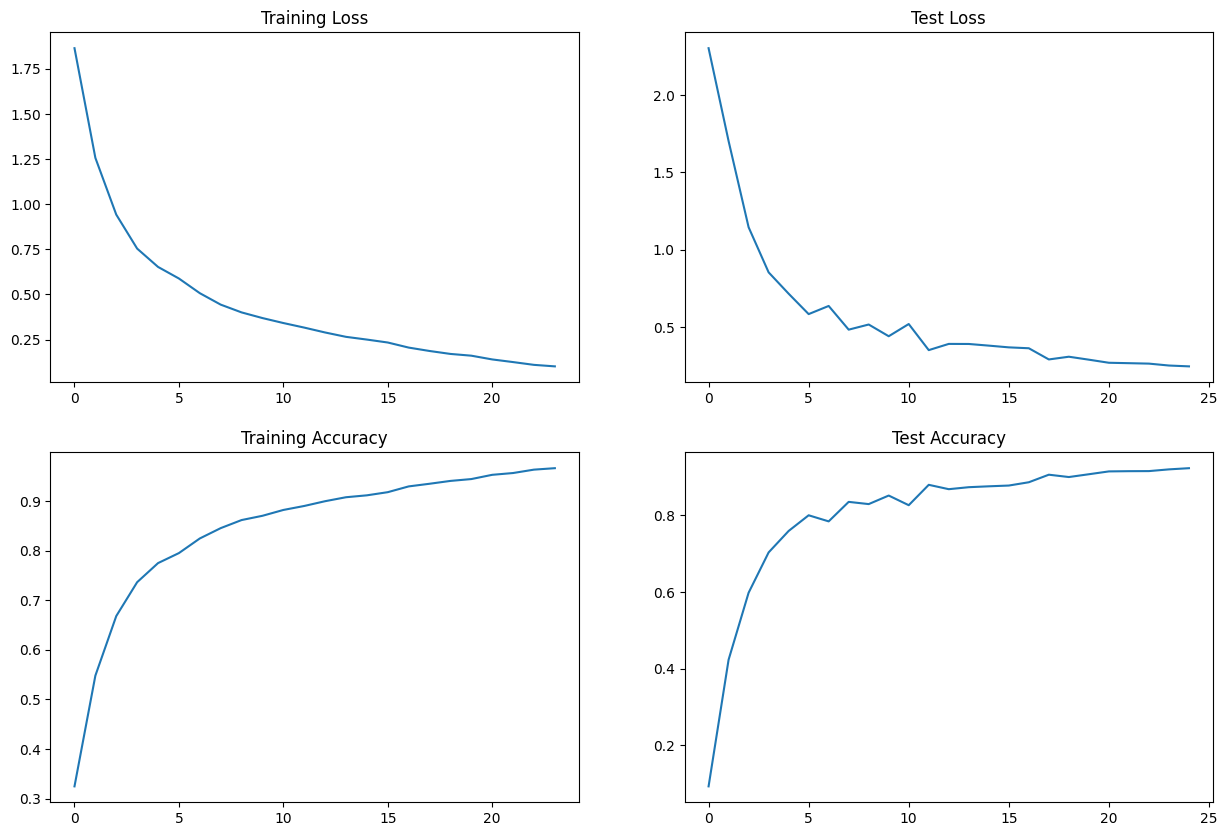

In [85]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelSummary
from Utilities.callbacks import TrainingEndCallback, PrintLearningMetricsCallback

trainer = pl.Trainer(accelerator=config.ACCELERATOR,
                     callbacks=[ModelSummary(max_depth=0), TrainingEndCallback(), PrintLearningMetricsCallback()],
                     min_epochs=config.NUM_EPOCHS, max_epochs=config.NUM_EPOCHS)
trainer.fit(model, datamodule=data_module)

# Testing & Evaluation

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


Epoch: 24, Test Loss: 0.2451956570148468, Test Accuracy: 0.9230999946594238


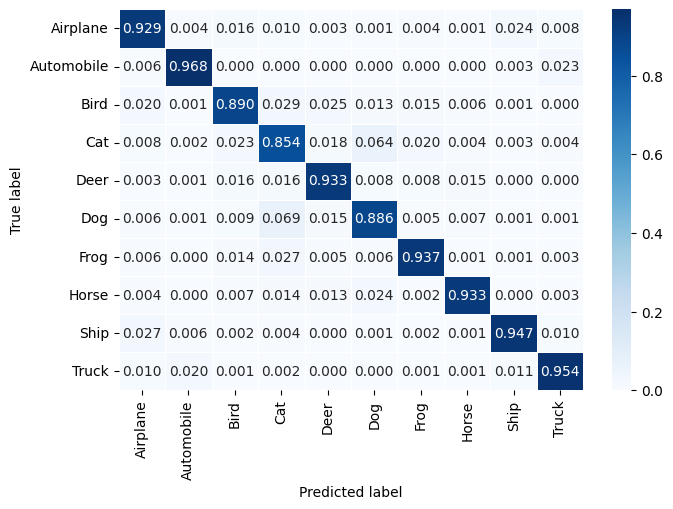

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.9230999946594238     │
│      test_loss_epoch      │    0.2451956570148468     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.2451956570148468, 'test_acc_epoch': 0.9230999946594238}]

In [86]:
trainer.test(model=model, datamodule=data_module, verbose=True)

Total Incorrect Predictions 769


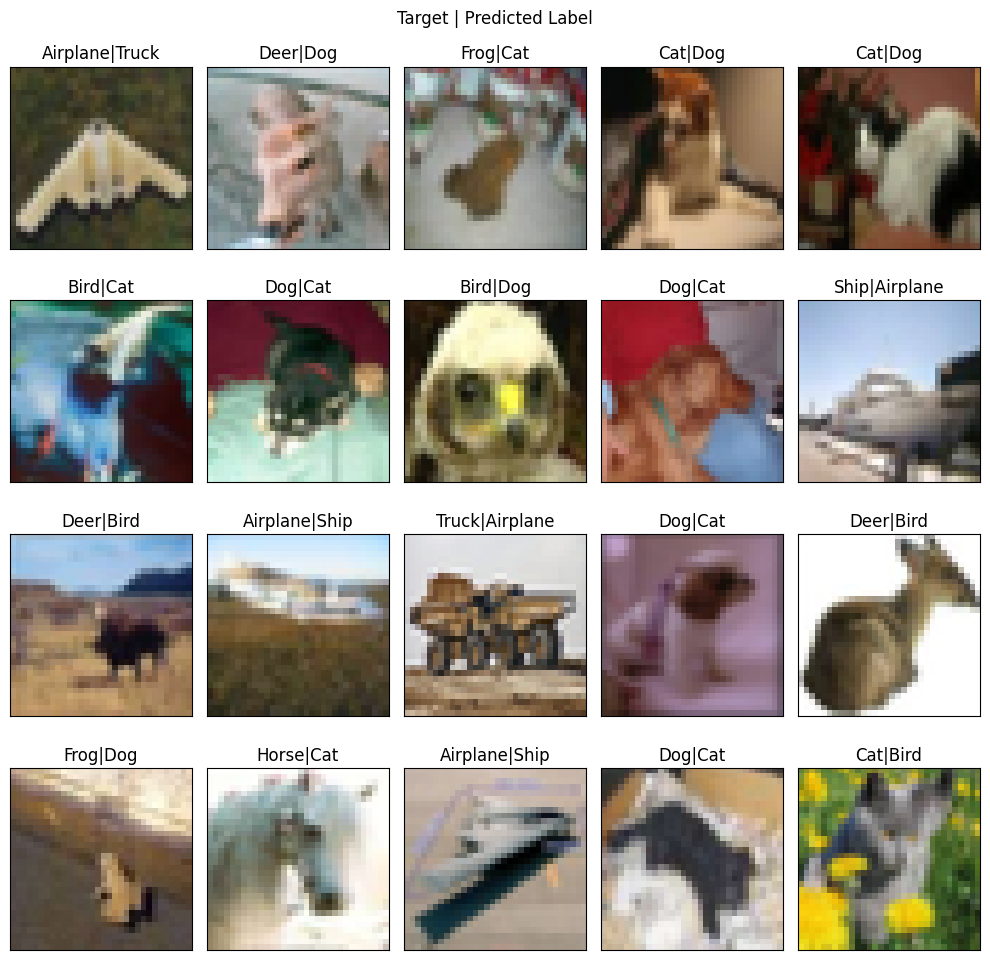

In [87]:
model.plot_incorrect_predictions_helper(num_imgs=20)

# Saving the model

In [89]:
torch.save(model.state_dict(), config.MODEL_SAVE_PATH)

### Git Push

In [100]:
! git remote set-url origin https://github.com/Madhur-1/ERA-v1.git
# ! git add .
# ! git commit -m "S12 commit 92.31%"
! git push

fatal: could not read Username for 'https://github.com': No such device or address
